In [1]:
import sys, os 
import numpy as np 
import pandas as pd
from src import utils, plots
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import rcParams
default_font = 12
fs_title = 16
rcParams["font.family"] = "Arial"
rcParams["savefig.dpi"] = 300
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.titlelocation"] = "left"
rcParams["axes.titleweight"] = "normal"
rcParams["font.size"] = default_font
trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange']

In [55]:
VG11 = []
VG11.append({'mname': 'VG11', 'datexp': '2024_10_31', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_14', 'blk':'2'})
VG14 = []
VG14.append({'mname': 'VG14', 'datexp': '2024_11_21', 'blk':'2'})
VG15 = []
VG15.append({'mname': 'VG15', 'datexp': '2024_10_31', 'blk':'2'})
all_sessions = VG11 + VG14 + VG15
all_sessions

[{'mname': 'VG11', 'datexp': '2024_10_31', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_14', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_11_21', 'blk': '2'},
 {'mname': 'VG15', 'datexp': '2024_10_31', 'blk': '2'}]

In [4]:
def datetime64_to_matlab_serial(dates):
    """
    Convert an array of datetime64 values to MATLAB serial date numbers.

    Parameters:
    dates (numpy.ndarray): Array of datetime64 values.

    Returns:
    list: List of MATLAB serial date numbers.
    """
    matlab_reference_date = datetime(1970, 1, 1)  # Unix epoch

    # Convert datetime64 to Python datetime
    python_datetimes = [pd.Timestamp(dt).to_pydatetime() for dt in dates]

    # Calculate the MATLAB serial date number
    matlab_serial_dates = []
    for dt in python_datetimes:
        delta = dt - matlab_reference_date
        matlab_serial_date = 719529 + delta.days + delta.seconds / 86400.0 + delta.microseconds / 86400.0 / 1e6
        matlab_serial_dates.append(matlab_serial_date)

    return np.array(matlab_serial_dates)

In [5]:
def datetime2datenum(dt):
    """ dt: list or array, y:m:d:h:m:s:ms """
    import datetime
    dtime = datetime.datetime(dt[0], dt[1], dt[2], dt[3], dt[4], dt[5], dt[6])
    mdn = dtime + datetime.timedelta(days = 366)
    frac_seconds = (dtime-datetime.datetime(dtime.year,dtime.month,dtime.day,0,0,0)).seconds / (24.0 * 60.0 * 60.0)
    frac_microseconds = dtime.microsecond / (24.0 * 60.0 * 60.0 * 1000000.0)
    return mdn.toordinal() + frac_seconds + frac_microseconds

datetime2datenum([2024, 10, 31, 14, 32, 12, 713107])

739556.605702698

In [42]:
pupil_path = "Z:\data\Miguel\Facevideos"
from pathlib import Path
pupil_path = Path(pupil_path)
p_path = Path.joinpath(pupil_path, m1.name, m1.datexp, m1.blk, f"{m1.name}_{m1.datexp}_{m1.blk}_full_proc.npy")
data = np.load(p_path, allow_pickle=True).item()
data.keys()

dict_keys(['filenames', 'save_path', 'Ly', 'Lx', 'sbin', 'fullSVD', 'save_mat', 'Lybin', 'Lxbin', 'sybin', 'sxbin', 'LYbin', 'LXbin', 'avgframe', 'avgmotion', 'avgframe_reshape', 'avgmotion_reshape', 'motion', 'motSv', 'movSv', 'motMask', 'movMask', 'motMask_reshape', 'movMask_reshape', 'motSVD', 'movSVD', 'pupil', 'running', 'blink', 'rois', 'sy', 'sx'])

In [45]:
data["motion"][1].shape

(153026,)

In [6]:
def get_pupil_df(m1, pupil_path: str = "Z:\data\Miguel\Facevideos"):
    from pathlib import Path
    pupil_path = Path(pupil_path)
    p_path = Path.joinpath(pupil_path, m1.name, m1.datexp, m1.blk, f"{m1.name}_{m1.datexp}_{m1.blk}_pupil.npy")
    pupil = np.load(p_path, allow_pickle=True)
    df = pd.DataFrame(pupil, columns=['Y', 'M', 'D', 'H', 'MM', 'S', 'MS', 'pupil_x', 'pupil_y', 'area'])
    df['time'] = df.apply(lambda x: datetime(x['Y'].astype(int), x['M'].astype(int), x['D'].astype(int), 
                                            x['H'].astype(int), x['MM'].astype(int), x['S'].astype(int), x['MS'].astype(int)), axis=1)
    df.drop(columns=['Y', 'M', 'D', 'H', 'MM', 'S', 'MS'], inplace=True)
    df['serialtime'] = df.apply(lambda x: datetime64_to_matlab_serial(np.array([x['time']]))[0], axis=1)
    return df

In [7]:
def get_frametimes(MouseObject):
    from scipy.interpolate import interp1d
    frames_time = MouseObject._data_var[0]
    ixx = (frames_time[:-1] > 2.5) * (frames_time[1:] < 2.5)
    iframes = np.argwhere(ixx).flatten()
    isamp = np.argwhere(MouseObject._data_var[1] > 1).flatten()
    ts = MouseObject._data_var[1][isamp]
    tframes = interp1d(isamp, ts)(iframes)
    nframes = len(tframes)
    return tframes, nframes

In [8]:
def load_cam_features(m1, camera_path: str = "Z:\data\Miguel\Facevideos"):
    from pathlib import Path
    camera_path = Path(camera_path)
    cam_path = Path.joinpath(camera_path, m1.name, m1.datexp, m1.blk, f"{m1.name}_{m1.datexp}_{m1.blk}_full_proc.npy")
    cam_proc = np.load(cam_path, allow_pickle=True).item()
    return cam_proc

In [9]:
def interp_to_corridor(frameselector, feature: str):
    ntrials = frameselector["trial_no"].astype(int).max()
    interp_feature = np.empty((ntrials, 400))
    for trial_no in frameselector["trial_no"].unique():
        trial_no = int(trial_no)
        trial_feature= frameselector.query(f"trial_no == {trial_no}")[feature].values
        trial_distance = frameselector.query(f"trial_no == {trial_no}")["distance"].values
        if (trial_distance[0] > 0) & (trial_no > 1):
            previous_trial_feature= frameselector.query(f"trial_no == {trial_no-1}")[feature].values[-1]
            #append 0 to the beginning
            trial_distance = np.insert(trial_distance, 0, 0)
            trial_feature = np.insert(trial_feature, 0, previous_trial_feature)
        elif (trial_distance[0] > 0) & (trial_no == 1):
            trial_distance = np.insert(trial_distance, 0, 0)
            trial_feature = np.insert(trial_feature, 0, trial_feature[0])
        trial_distance = np.round(trial_distance, 0).astype(int)
        interp_feature[trial_no-1] = np.interp(np.arange(400), trial_distance, trial_feature)
    return interp_feature

In [10]:
def plot_feature(feature, ylabel: str, labelypos: int = 60, ylabel_offset: int = 0):
    from scipy.stats import sem
    cat_a = feature[:,[0,2],:].mean(1)
    cat_b = feature[:,[1,3],:].mean(1)
    rew_gran_mean = cat_a.mean(axis=0)
    rew_gran_sem = sem(cat_a, axis=0)
    nrew_gran_mean = cat_b.mean(axis=0)
    nrew_gran_sem = sem(cat_b, axis=0)
    fig, ax = plt.subplots(1,2, figsize=(8, 4), sharex=True, sharey=True)
    ax[0].plot(rew_gran_mean[0], color='tab:green')
    ax[0].fill_between(np.arange(400), rew_gran_mean[0]-rew_gran_sem[0], rew_gran_mean[0]+rew_gran_sem[0], alpha=0.3, color='tab:green')
    ax[0].plot(nrew_gran_mean[0], color='tab:red')
    ax[0].fill_between(np.arange(400), nrew_gran_mean[0]-nrew_gran_sem[0], nrew_gran_mean[0]+nrew_gran_sem[0], alpha=0.3, color='tab:red')
    ax[1].plot(rew_gran_mean[1],  color='tab:green')
    ax[1].fill_between(np.arange(400), rew_gran_mean[1]-rew_gran_sem[1], rew_gran_mean[1]+rew_gran_sem[1], alpha=0.3, color='tab:green')
    ax[1].plot(nrew_gran_mean[1], color='tab:red')
    ax[1].fill_between(np.arange(400), nrew_gran_mean[1]-nrew_gran_sem[1], nrew_gran_mean[1]+nrew_gran_sem[1], alpha=0.3, color='tab:red')
    ax[0].set_ylabel(ylabel)
    ax[0].text(10,labelypos + ylabel_offset, "Active reward collection trials", color='tab:green')
    ax[0].text(10,labelypos, "Non rewarded trials with licks", color='tab:red')
    ax[1].text(10,labelypos + ylabel_offset, "Ignored rewarded trials", color='tab:green')
    ax[1].text(10,labelypos, "Correctly ommited non rewarded trials", color='tab:red')
    for i in range(2):
        ax[i].set_xlabel("Position (cm)")
        ax[i].axvline(150, color='k', linestyle='--', alpha=0.5)
        ax[i].axvline(250, color='k', linestyle='--', alpha=0.5)
        ax[i].axvline(300, color='k', linestyle='--', alpha=0.5)

In [273]:
from scipy.interpolate import interp1d
from pathlib import Path
svds_path = Path("Z:\data\Miguel\Facevideos")
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
    cam_proc = load_cam_features(m1, svds_path)
    motSVD = cam_proc['motSVD'][1]
    movSVD = cam_proc['movSVD'][1]
    pupil_df = get_pupil_df(m1, svds_path)
    tframes, nframes = get_frametimes(m1)
    camera_time = pupil_df['serialtime'].values
    interp_movSVD0 = interp1d(camera_time, movSVD[:,0], fill_value="extrapolate")(tframes)
    interp_motSVD0 = interp1d(camera_time, motSVD[:,0], fill_value="extrapolate")(tframes)
    interp_pupil_x = interp1d(camera_time, pupil_df['pupil_x'].values, fill_value="extrapolate")(tframes)
    interp_pupil_y = interp1d(camera_time, pupil_df['pupil_y'].values, fill_value="extrapolate")(tframes)
    interp_area = interp1d(camera_time, pupil_df['area'].values, fill_value="extrapolate")(tframes)
    cam_df = pd.DataFrame({'movSVD0': interp_movSVD0, 'motSVD0': interp_motSVD0, 
                        'pupil_x': interp_pupil_x, 'pupil_y': interp_pupil_y, 'pupil_area': interp_area})
    fselector = pd.merge(m1.frameselector, cam_df, left_index=True, right_index=True)
    interp_movSVD0 = interp_to_corridor(fselector, 'movSVD0')
    interp_motSVD0 = interp_to_corridor(fselector, 'motSVD0')
    interp_pupil_x = interp_to_corridor(fselector, 'pupil_x')
    interp_pupil_y = interp_to_corridor(fselector, 'pupil_y')
    interp_area = interp_to_corridor(fselector, 'pupil_area')
    features = [interp_movSVD0, interp_motSVD0, interp_pupil_x, interp_pupil_y, interp_area]
    f_names = ['movSVD0', 'motSVD0', 'pupil_x', 'pupil_y', 'pupil_area']
    for i in range(len(features)):
        pth = Path(f"../data/{m1.name}/{m1.datexp}/{m1.blk}")
        np.save(pth/f"{f_names[i]}_corridor.npy", features[i])

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

In [11]:
mean_movSVD0_per_trial_type = np.empty((len(all_sessions), 4, 400)) # animals, trial types,  400 positions
mean_motSVD0_per_trial_type = np.empty((len(all_sessions), 4, 400)) # animals, trial types, 400 positions
mean_pupilx_per_trial_type = np.empty((len(all_sessions), 4, 400)) # animals, trial types,  400 positions
mean_pupily_per_trial_type = np.empty((len(all_sessions), 4, 400)) # animals, trial types, 400 positions
mean_pupilarea_per_trial_type = np.empty((len(all_sessions), 4, 400)) # animals, trial types, 400 positions
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
    movSVD0 = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/movSVD0_corridor.npy")
    motSVD0 = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/motSVD0_corridor.npy")
    pupil_x = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/pupil_x_corridor.npy")
    pupil_y = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/pupil_y_corridor.npy")
    pupil_area = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/pupil_area_corridor.npy")
    f = [movSVD0, motSVD0, pupil_x, pupil_y, pupil_area]
    for i, feature in enumerate(f):
        feature_no_offset = feature - np.expand_dims(feature[:,0],axis=1)
        for it, (ttype, trials) in enumerate(m1.trial_dict.items()):
            mean_feature = np.mean(feature_no_offset[trials], axis=0)
            if i == 0:
                mean_movSVD0_per_trial_type[iss, it] =  mean_feature
            elif i == 1:
                mean_motSVD0_per_trial_type[iss, it] =  mean_feature
            elif i == 2:
                mean_pupilx_per_trial_type[iss, it] =  mean_feature
            elif i == 3: 
                mean_pupily_per_trial_type[iss, it] =  mean_feature
            elif i == 4:
                mean_pupilarea_per_trial_type[iss, it] =  mean_feature
np.save("../data/overall/mean_movSVD0_per_trial_type.npy", mean_movSVD0_per_trial_type)
np.save("../data/overall/mean_motSVD0_per_trial_type.npy", mean_motSVD0_per_trial_type)
np.save("../data/overall/mean_pupilx_per_trial_type.npy", mean_pupilx_per_trial_type)
np.save("../data/overall/mean_pupily_per_trial_type.npy", mean_pupily_per_trial_type)
np.save("../data/overall/mean_pupilarea_per_trial_type.npy", mean_pupilarea_per_trial_type)

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

In [24]:
def significance(pval):
    if pval >= 0.05:
        text =  "n.s."
    elif pval < 0.05:
        text = "*"
    elif pval < 0.01 & pval >= 0.001:
        text = "**"
    else:
        text = "***"
    return text

In [12]:
mean_movSVD0_per_cat = np.empty((len(all_sessions), 2, 400)) # animals, cats,  400 positions
mean_motSVD0_per_cat  = np.empty((len(all_sessions), 2, 400)) # animals, cats, 400 positions
mean_pupilx_per_cat  = np.empty((len(all_sessions), 2, 400)) # animals, cats,  400 positions
mean_pupily_per_cat  = np.empty((len(all_sessions), 2, 400)) # animals, cats, 400 positions
mean_pupilarea_per_cat  = np.empty((len(all_sessions), 2, 400)) # animals, cats, 400 positions
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
    movSVD0 = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/movSVD0_corridor.npy")
    motSVD0 = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/motSVD0_corridor.npy")
    pupil_x = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/pupil_x_corridor.npy")
    pupil_y = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/pupil_y_corridor.npy")
    pupil_area = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/pupil_area_corridor.npy")
    f = [movSVD0, motSVD0, pupil_x, pupil_y, pupil_area]
    A_trials = np.concatenate([m1.trial_dict['rewarded'], m1.trial_dict['rewarded test']])
    B_trials = np.concatenate([m1.trial_dict['non rewarded'], m1.trial_dict['non rewarded test']])
    for i, feature in enumerate(f):
        feature_no_offset = feature - np.expand_dims(feature[:,0],axis=1)
        for it, trials in enumerate([A_trials, B_trials]):
            mean_feature = np.mean(feature_no_offset[trials], axis=0)
            if i == 0:
                mean_movSVD0_per_cat [iss, it] =  mean_feature
            elif i == 1:
                mean_motSVD0_per_cat [iss, it] =  mean_feature
            elif i == 2:
                mean_pupilx_per_cat [iss, it] =  mean_feature
            elif i == 3: 
                mean_pupily_per_cat [iss, it] =  mean_feature
            elif i == 4:
                mean_pupilarea_per_cat [iss, it] =  mean_feature
np.save("../data/overall/mean_movSVD0_per_cat.npy", mean_movSVD0_per_cat )
np.save("../data/overall/mean_motSVD0_per_cat.npy", mean_motSVD0_per_cat )
np.save("../data/overall/mean_pupilx_per_cat.npy", mean_pupilx_per_cat )
np.save("../data/overall/mean_pupily_per_cat.npy", mean_pupily_per_cat )
np.save("../data/overall/mean_pupilarea_per_cat.npy", mean_pupilarea_per_cat )


Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

n.s.
n.s.


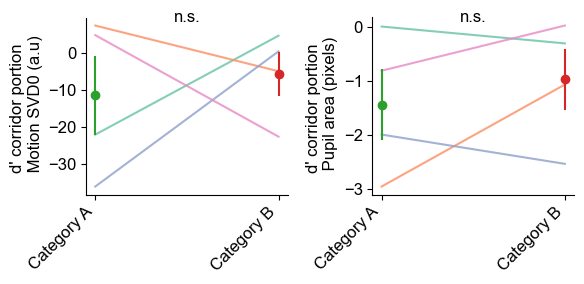

In [28]:
from scipy.stats import sem
from scipy.stats import ttest_rel
f = [mean_motSVD0_per_cat, mean_pupilarea_per_cat]
f_names  = ["Motion SVD0 (a.u)", "Pupil area (pixels)"]
fig, ax = plt.subplots(1,2, figsize=(6, 3))
for i, feature in enumerate(f):   
    overall_A = feature[:,0,:125].mean(-1)
    overall_B = feature[:,1,:125].mean(-1)
    overall_A_sem = sem(overall_A, axis=0)
    overall_B_sem = sem(overall_B, axis=0)

    
    ax[i].errorbar(-.1, overall_A.mean(0), yerr=overall_A_sem, color='tab:green')
    ax[i].errorbar(.1, overall_B.mean(0), yerr=overall_B_sem, color='tab:red')
    ax[i].scatter(-.1, overall_A.mean(0), color='tab:green')
    ax[i].scatter(.1, overall_B.mean(0), color='tab:red')
    ax[i].set_ylabel(f"d' corridor portion \n {f_names[i]}")
    ax[i].set_xticks([-.1,.1], ["Category A", "Category B"], rotation=45, ha='right');
    # connect dots 
    mouse_colors = sns.color_palette("Set2", 4)
    for animal in range(4):
        ax[i].plot([-.1,.1], [overall_A[animal], overall_B[animal]], color=mouse_colors[animal], alpha=0.8, zorder=0)
    t, p = ttest_rel(overall_A, overall_B)
    ptext = significance(p)
    print(ptext)
    ax[i].text(.5, 1, ptext, ha='center', va='center', transform=ax[i].transAxes)
plt.tight_layout()

In [38]:
def plot_feature_comparison(feature, fname: str, ax):
    overall_A = feature[:,0,:125].mean(-1)
    overall_B = feature[:,1,:125].mean(-1)
    overall_A_sem = sem(overall_A, axis=0)
    overall_B_sem = sem(overall_B, axis=0)
    ax.errorbar(-.1, overall_A.mean(0), yerr=overall_A_sem, color='tab:green')
    ax.errorbar(.1, overall_B.mean(0), yerr=overall_B_sem, color='tab:red')
    ax.scatter(-.1, overall_A.mean(0), color='tab:green')
    ax.scatter(.1, overall_B.mean(0), color='tab:red')
    ax.set_ylabel(f"d' corridor portion \n {fname}")
    ax.set_xticks([-.1,.1], ["Category A", "Category B"], rotation=45, ha='right');
    # connect dots 
    mouse_colors = sns.color_palette("Set2", 4)
    for animal in range(4):
        ax.plot([-.1,.1], [overall_A[animal], overall_B[animal]], color=mouse_colors[animal], alpha=0.8, zorder=0)
    t, p = ttest_rel(overall_A, overall_B)
    ptext = significance(p)
    ax.text(.5, 1, ptext, ha='center', va='center', transform=ax.transAxes)

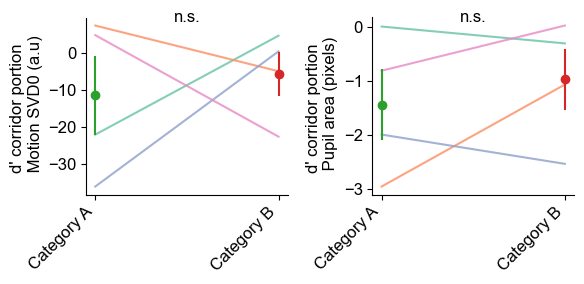

In [40]:
f = [mean_motSVD0_per_cat, mean_pupilarea_per_cat]
f_names  = ["Motion SVD0 (a.u)", "Pupil area (pixels)"]
fig, ax = plt.subplots(1,2, figsize=(6, 3))
for i, feature in enumerate(f): 
    plot_feature_comparison(feature, f_names[i], ax[i])
plt.tight_layout()

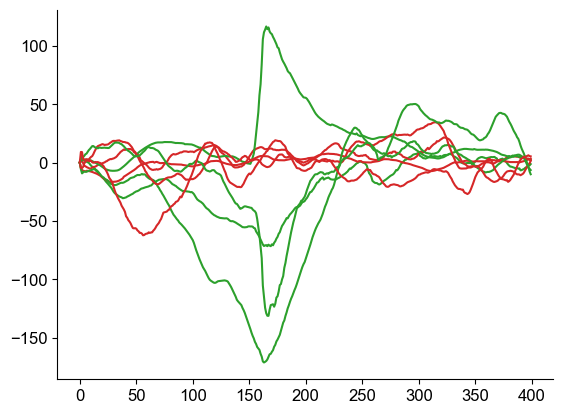

In [30]:
for i in range(4):
    plt.plot(mean_motSVD0_per_cat[i,0], color='tab:green')
    plt.plot(mean_motSVD0_per_cat[i,1], color='tab:red')

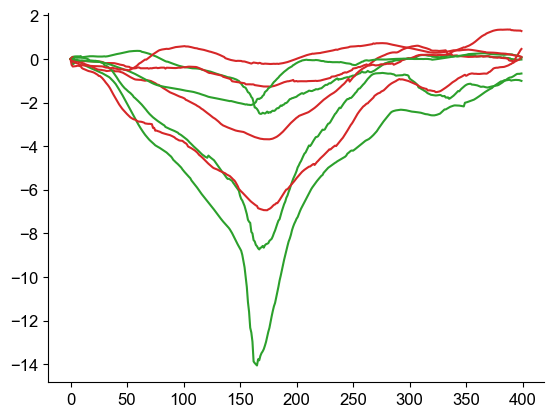

In [31]:
for i in range(4):
    plt.plot(mean_pupilarea_per_cat[i,0], color='tab:green')
    plt.plot(mean_pupilarea_per_cat[i,1], color='tab:red')

In [274]:
mean_movSVD0_per_trial_type_andlick = np.empty((len(all_sessions), 4, 2, 400)) # animals, trial types, lick/no lick, 400 positions
mean_motSVD0_per_trial_type_andlick = np.empty((len(all_sessions), 4, 2, 400)) # animals, trial types, lick/no lick, 400 positions
mean_pupilx_per_trial_type_andlick = np.empty((len(all_sessions), 4, 2, 400)) # animals, trial types, lick/no lick, 400 positions
mean_pupily_per_trial_type_andlick = np.empty((len(all_sessions), 4, 2, 400)) # animals, trial types, lick/no lick, 400 positions
mean_pupilarea_per_trial_type_andlick = np.empty((len(all_sessions), 4, 2, 400)) # animals, trial types, lick/no lick, 400 positions
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
    movSVD0 = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/movSVD0_corridor.npy")
    motSVD0 = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/motSVD0_corridor.npy")
    pupil_x = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/pupil_x_corridor.npy")
    pupil_y = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/pupil_y_corridor.npy")
    pupil_area = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/pupil_area_corridor.npy")
    f = [movSVD0, motSVD0, pupil_x, pupil_y, pupil_area]
    for it, (ttype, trials) in enumerate(m1.trial_dict.items()):
        t_licks, t_no_licks = utils.get_trials_with_licks(m1, lick_window=(150,250), trialtype=ttype)
        for i, feature in enumerate(f):
            mean_licks = np.mean(feature[t_licks], axis=0)
            mean_no_licks = np.mean(feature[t_no_licks], axis=0)
            if i == 0:
                mean_movSVD0_per_trial_type_andlick[iss, it, 0] =  mean_licks
                mean_movSVD0_per_trial_type_andlick[iss, it, 1] =  mean_no_licks
            elif i == 1:
                mean_motSVD0_per_trial_type_andlick[iss, it, 0] =  mean_licks
                mean_motSVD0_per_trial_type_andlick[iss, it, 1] =  mean_no_licks
            elif i == 2:
                mean_pupilx_per_trial_type_andlick[iss, it, 0] =  mean_licks
                mean_pupilx_per_trial_type_andlick[iss, it, 1] =  mean_no_licks
            elif i == 3:
                mean_pupily_per_trial_type_andlick[iss, it, 0] =  mean_licks
                mean_pupily_per_trial_type_andlick[iss, it, 1] =  mean_no_licks
            elif i == 4:
                mean_pupilarea_per_trial_type_andlick[iss, it, 0] =  mean_licks
                mean_pupilarea_per_trial_type_andlick[iss, it, 1] =  mean_no_licks
np.save("../data/overall/mean_movSVD0_per_trial_type_andlick.npy", mean_movSVD0_per_trial_type_andlick)
np.save("../data/overall/mean_motSVD0_per_trial_type_andlick.npy", mean_motSVD0_per_trial_type_andlick)
np.save("../data/overall/mean_pupilx_per_trial_type_andlick.npy", mean_pupilx_per_trial_type_andlick)
np.save("../data/overall/mean_pupily_per_trial_type_andlick.npy", mean_pupily_per_trial_type_andlick)
np.save("../data/overall/mean_pupilarea_per_trial_type_andlick.npy", mean_pupilarea_per_trial_type_andlick)

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

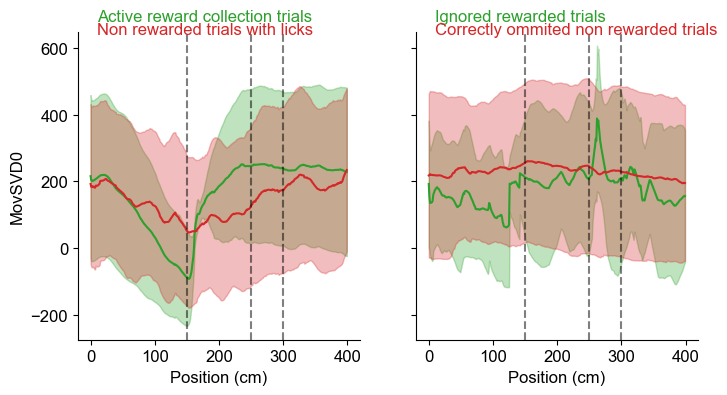

In [283]:
plot_feature(mean_movSVD0_per_trial_type_andlick, "MovSVD0", 640, 40)

Ttest_relResult(statistic=-0.24109443329189784, pvalue=0.8250203105182121)
Ttest_relResult(statistic=-1.8116983870761467, pvalue=0.16770559194372697)


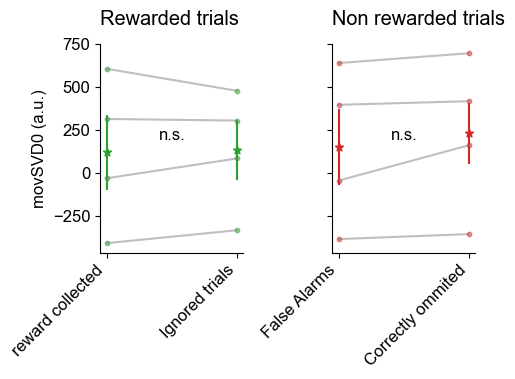

In [308]:
from scipy.stats import sem
cat_a = mean_movSVD0_per_trial_type_andlick[:,[0,2],:].mean(1)
cat_b = mean_movSVD0_per_trial_type_andlick[:,[1,3],:].mean(1)
overall_feature_A = cat_a[:,:,0:125].mean(-1)
overall_feature_B = cat_b[:,:,0:125].mean(-1)
overall_feature_A_sem = sem(overall_feature_A, axis=0)
overall_feature_B_sem = sem(overall_feature_B, axis=0)

fig, ax = plt.subplots(1,2, figsize=(5, 4), sharey=True)
for animal in range(4):
    ax[0].scatter(0,overall_feature_A[animal,0], color='tab:green', label="Active reward collection", alpha=0.5, s=10)
    ax[0].scatter(1,overall_feature_A[animal,1],  color='tab:green', label="Ignored rewarded trials", alpha=0.5, s=10)
    ax[1].scatter(0,overall_feature_B[animal,0], color='tab:red', label="Non rewarded trials with licks", alpha=0.5, s=10)
    ax[1].scatter(1,overall_feature_B[animal,1], color='tab:red', label="Correctly ommited non rewarded trials",alpha=0.5, s=10)
ax[0].errorbar(0, overall_feature_A.mean(0)[0], yerr=overall_feature_A_sem[0], color='tab:green')
ax[0].scatter(0, overall_feature_A.mean(0)[0], marker='*', color='tab:green')
ax[0].errorbar(1, overall_feature_A.mean(0)[1], yerr=overall_feature_A_sem[1], color='tab:green')
ax[0].scatter(1, overall_feature_A.mean(0)[1], marker='*', color='tab:green')
ax[1].errorbar(0, overall_feature_B.mean(0)[0], yerr=overall_feature_A_sem[0], color='tab:red')
ax[1].scatter(0, overall_feature_B.mean(0)[0], marker='*', color='tab:red')
ax[1].errorbar(1, overall_feature_B.mean(0)[1], yerr=overall_feature_A_sem[1], color='tab:red')
ax[1].scatter(1, overall_feature_B.mean(0)[1], marker='*', color='tab:red')
ax[0].set_ylabel("movSVD0 (a.u.)")
ax[0].set_title("Rewarded trials", y=1.05)
ax[1].set_title("Non rewarded trials", y=1.05)
ax[0].set_xticks([0,1], ["reward collected", "Ignored trials"], rotation=45, ha='right');
ax[1].set_xticks([0,1], ["False Alarms", "Correctly ommited"], rotation=45, ha='right');
# connect dots 
for animal in range(4):
    ax[0].plot([0,1], [overall_feature_A[animal,0], overall_feature_A[animal,1]], color='grey', alpha=0.5)
    ax[1].plot([0,1], [overall_feature_B[animal,0], overall_feature_B[animal,1]], color='grey', alpha=0.5)
ax[0].text(0.4, 190, "n.s.")
ax[1].text(0.4, 190, "n.s.")
plt.tight_layout()
# compute the paired ttest between the two conditions
from scipy.stats import ttest_rel
print(ttest_rel(overall_feature_A[:,0], overall_feature_A[:,1]))
print(ttest_rel(overall_feature_B[:,0], overall_feature_B[:,1]))

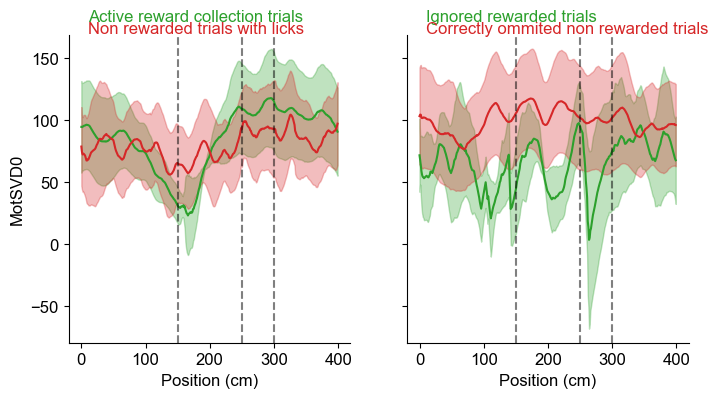

In [290]:
plot_feature(mean_motSVD0_per_trial_type_andlick, "MotSVD0", 170, 10)

Ttest_relResult(statistic=1.4404325362360697, pvalue=0.245378984292006)
Ttest_relResult(statistic=-2.3528856149864747, pvalue=0.10004337362863448)


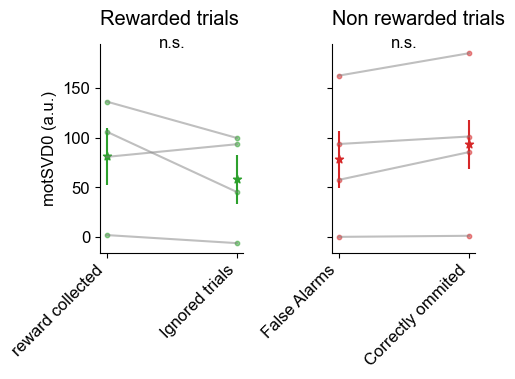

In [302]:
from scipy.stats import sem
cat_a = mean_motSVD0_per_trial_type_andlick[:,[0,2],:].mean(1)
cat_b = mean_motSVD0_per_trial_type_andlick[:,[1,3],:].mean(1)
overall_feature_A = cat_a[:,:,0:125].mean(-1)
overall_feature_B = cat_b[:,:,0:125].mean(-1)
overall_feature_A_sem = sem(overall_feature_A, axis=0)
overall_feature_B_sem = sem(overall_feature_B, axis=0)

fig, ax = plt.subplots(1,2, figsize=(5, 4), sharey=True)
for animal in range(4):
    ax[0].scatter(0,overall_feature_A[animal,0], color='tab:green', label="Active reward collection", alpha=0.5, s=10)
    ax[0].scatter(1,overall_feature_A[animal,1],  color='tab:green', label="Ignored rewarded trials", alpha=0.5, s=10)
    ax[1].scatter(0,overall_feature_B[animal,0], color='tab:red', label="Non rewarded trials with licks", alpha=0.5, s=10)
    ax[1].scatter(1,overall_feature_B[animal,1], color='tab:red', label="Correctly ommited non rewarded trials",alpha=0.5, s=10)
ax[0].errorbar(0, overall_feature_A.mean(0)[0], yerr=overall_feature_A_sem[0], color='tab:green')
ax[0].scatter(0, overall_feature_A.mean(0)[0], marker='*', color='tab:green')
ax[0].errorbar(1, overall_feature_A.mean(0)[1], yerr=overall_feature_A_sem[1], color='tab:green')
ax[0].scatter(1, overall_feature_A.mean(0)[1], marker='*', color='tab:green')
ax[1].errorbar(0, overall_feature_B.mean(0)[0], yerr=overall_feature_A_sem[0], color='tab:red')
ax[1].scatter(0, overall_feature_B.mean(0)[0], marker='*', color='tab:red')
ax[1].errorbar(1, overall_feature_B.mean(0)[1], yerr=overall_feature_A_sem[1], color='tab:red')
ax[1].scatter(1, overall_feature_B.mean(0)[1], marker='*', color='tab:red')
ax[0].set_ylabel("motSVD0 (a.u.)")
ax[0].set_title("Rewarded trials", y=1.05)
ax[1].set_title("Non rewarded trials", y=1.05)
ax[0].set_xticks([0,1], ["reward collected", "Ignored trials"], rotation=45, ha='right');
ax[1].set_xticks([0,1], ["False Alarms", "Correctly ommited"], rotation=45, ha='right');
# connect dots 
for animal in range(4):
    ax[0].plot([0,1], [overall_feature_A[animal,0], overall_feature_A[animal,1]], color='grey', alpha=0.5)
    ax[1].plot([0,1], [overall_feature_B[animal,0], overall_feature_B[animal,1]], color='grey', alpha=0.5)
ax[0].text(0.4, 190, "n.s.")
ax[1].text(0.4, 190, "n.s.")
plt.tight_layout()
# compute the paired ttest between the two conditions
from scipy.stats import ttest_rel
print(ttest_rel(overall_feature_A[:,0], overall_feature_A[:,1]))
print(ttest_rel(overall_feature_B[:,0], overall_feature_B[:,1]))

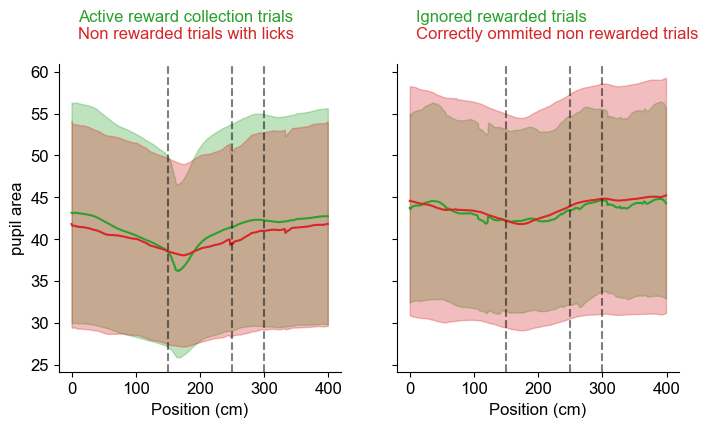

In [298]:
plot_feature(mean_pupilarea_per_trial_type_andlick, "pupil area", 64, 2)

Ttest_relResult(statistic=-0.6705567030301409, pvalue=0.5505083432387352)
Ttest_relResult(statistic=-1.1611489861307451, pvalue=0.3295772295735802)


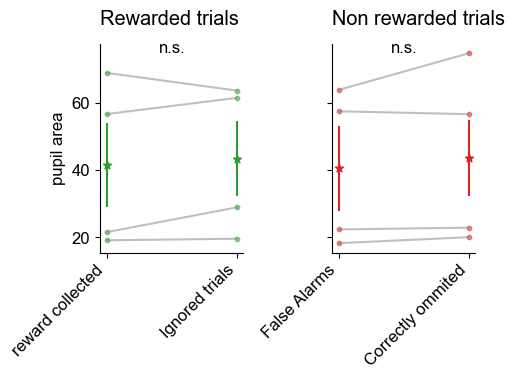

In [307]:
from scipy.stats import sem
cat_a = mean_pupilarea_per_trial_type_andlick[:,[0,2],:].mean(1)
cat_b = mean_pupilarea_per_trial_type_andlick[:,[1,3],:].mean(1)
overall_feature_A = cat_a[:,:,0:125].mean(-1)
overall_feature_B = cat_b[:,:,0:125].mean(-1)
overall_feature_A_sem = sem(overall_feature_A, axis=0)
overall_feature_B_sem = sem(overall_feature_B, axis=0)

fig, ax = plt.subplots(1,2, figsize=(5, 4), sharey=True)
for animal in range(4):
    ax[0].scatter(0,overall_feature_A[animal,0], color='tab:green', label="Active reward collection", alpha=0.5, s=10)
    ax[0].scatter(1,overall_feature_A[animal,1],  color='tab:green', label="Ignored rewarded trials", alpha=0.5, s=10)
    ax[1].scatter(0,overall_feature_B[animal,0], color='tab:red', label="Non rewarded trials with licks", alpha=0.5, s=10)
    ax[1].scatter(1,overall_feature_B[animal,1], color='tab:red', label="Correctly ommited non rewarded trials",alpha=0.5, s=10)
ax[0].errorbar(0, overall_feature_A.mean(0)[0], yerr=overall_feature_A_sem[0], color='tab:green')
ax[0].scatter(0, overall_feature_A.mean(0)[0], marker='*', color='tab:green')
ax[0].errorbar(1, overall_feature_A.mean(0)[1], yerr=overall_feature_A_sem[1], color='tab:green')
ax[0].scatter(1, overall_feature_A.mean(0)[1], marker='*', color='tab:green')
ax[1].errorbar(0, overall_feature_B.mean(0)[0], yerr=overall_feature_A_sem[0], color='tab:red')
ax[1].scatter(0, overall_feature_B.mean(0)[0], marker='*', color='tab:red')
ax[1].errorbar(1, overall_feature_B.mean(0)[1], yerr=overall_feature_A_sem[1], color='tab:red')
ax[1].scatter(1, overall_feature_B.mean(0)[1], marker='*', color='tab:red')
ax[0].set_ylabel("pupil area")
ax[0].set_title("Rewarded trials", y=1.05)
ax[1].set_title("Non rewarded trials", y=1.05)
ax[0].set_xticks([0,1], ["reward collected", "Ignored trials"], rotation=45, ha='right');
ax[1].set_xticks([0,1], ["False Alarms", "Correctly ommited"], rotation=45, ha='right');
# connect dots 
for animal in range(4):
    ax[0].plot([0,1], [overall_feature_A[animal,0], overall_feature_A[animal,1]], color='grey', alpha=0.5)
    ax[1].plot([0,1], [overall_feature_B[animal,0], overall_feature_B[animal,1]], color='grey', alpha=0.5)
ax[0].text(0.4, 75, "n.s.")
ax[1].text(0.4, 75, "n.s.")
plt.tight_layout()
# compute the paired ttest between the two conditions
from scipy.stats import ttest_rel
print(ttest_rel(overall_feature_A[:,0], overall_feature_A[:,1]))
print(ttest_rel(overall_feature_B[:,0], overall_feature_B[:,1]))

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

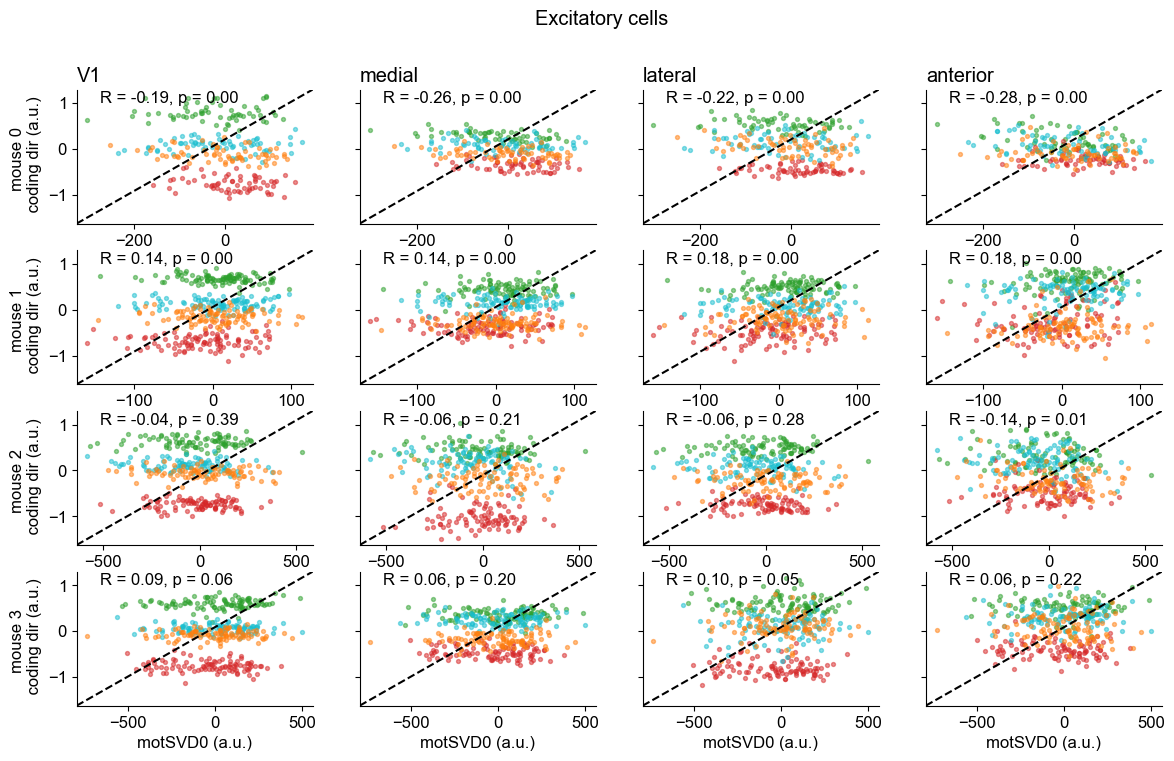

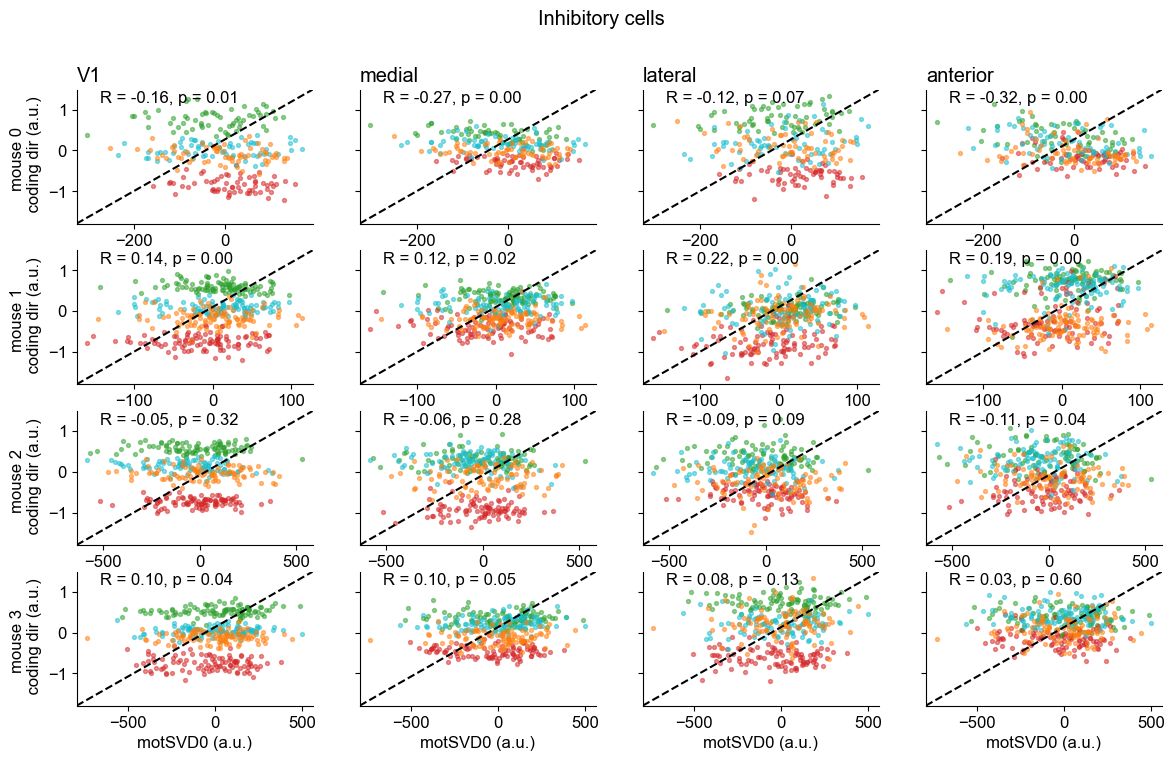

In [ ]:
from scipy.stats import pearsonr
areas = ["V1", "medial", "lateral", "anterior"]

for redcell in range(2):
    fig, ax = plt.subplots(4,4, figsize=(14, 8), sharey=True)
    
    if redcell == 0: 
        title = "Excitatory cells"
    else:
        title = "Inhibitory cells"
        fig.suptitle(f"{title}")
    for iss, sess in enumerate(all_sessions):
        name = sess['mname']
        date = sess['datexp']
        blk = sess['blk']
        ax[iss, 0].set_ylabel(f"mouse {iss} \n coding dir (a.u.)")
        m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
        motSVD0 = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/motSVD0_corridor.npy")
        pupil_area = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/pupil_area_corridor.npy")
        motSVD0 = motSVD0 - np.expand_dims(motSVD0[:,0],axis=1)
        motSVD0 = motSVD0[:,:125].mean(axis=1)
        f = [motSVD0, pupil_area]
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
            title = "Excitatory cells"
        else:
            selected_type = m1.isred[:,0].astype(bool)
            title = "Inhibitory cells"
        fig.suptitle(f"{title}")
        for indexa, area in enumerate(areas):
            ax[0, indexa].set_title(area)
            ax[-1, indexa].set_xlabel(f"motSVD0 (a.u.)")
            ia = utils.get_region_idx(m1.iarea, area)
            pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
            prefer_r = (m1.train_dp>=pstv_tsh)
            prefer_nr = (m1.train_dp<=ngtv_tsh)
            area_prefer_r = prefer_r * ia * selected_type
            area_prefer_nr = prefer_nr * ia * selected_type
            dir_for_type = m1.interp_spks 
            dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
            avg_dir = dir_for_type.mean(0)
            avg_dir = avg_dir[:,:125].mean(axis=1)
            ax[iss, indexa].plot([0, 1], [0, 1], transform=ax[iss, indexa].transAxes, color='k', linestyle='--')
            ax[iss, indexa].text(.1, .9, transform=ax[iss,indexa].transAxes, s=f"R = {pearsonr(motSVD0, avg_dir)[0]:.2f}, p = {pearsonr(motSVD0, avg_dir)[1]:.2f}")
            for it, (ttype, trials) in enumerate(m1.trial_dict.items()):
                ax[iss, indexa].scatter(motSVD0[trials], avg_dir[trials], color=trial_type_palette[it], label=ttype, alpha=0.5, s=8)
            

In [400]:
from scipy.stats import pearsonr
areas = ["V1", "medial", "lateral", "anterior"]
cod_dirs = np.empty((len(all_sessions), 4, 2), dtype=object)
mot_svds = np.empty((len(all_sessions), 4, 2), dtype=object)
pupil_areas = np.empty((len(all_sessions), 4, 2), dtype=object)
cod_motsvd_corr = np.empty((len(all_sessions), 4, 2))
cod_pupil_corr = np.empty((len(all_sessions), 4, 2))
cod_motsvd_p = np.empty((len(all_sessions), 4, 2))
cod_pupil_p = np.empty((len(all_sessions), 4, 2))
for redcell in range(2):
    if redcell == 0: 
        title = "Excitatory cells"
    else:
        title = "Inhibitory cells"
    for iss, sess in enumerate(all_sessions):
        name = sess['mname']
        date = sess['datexp']
        blk = sess['blk']
        m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
        motSVD0 = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/motSVD0_corridor.npy")
        pupil_area = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/pupil_area_corridor.npy")
        motSVD0 = motSVD0 - np.expand_dims(motSVD0[:,0],axis=1)
        motSVD0 = motSVD0[:,:125].mean(axis=1)
        pupil_area = pupil_area - np.expand_dims(pupil_area[:,0],axis=1)
        pupil_area = pupil_area[:,:125].mean(axis=1)
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        for indexa, area in enumerate(areas):
            ia = utils.get_region_idx(m1.iarea, area)
            pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
            prefer_r = (m1.train_dp>=pstv_tsh)
            prefer_nr = (m1.train_dp<=ngtv_tsh)
            area_prefer_r = prefer_r * ia * selected_type
            area_prefer_nr = prefer_nr * ia * selected_type
            dir_for_type = m1.interp_spks 
            dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
            avg_dir = dir_for_type.mean(0)
            avg_dir = avg_dir[:,:125].mean(axis=1)
            cod_motsvd_corr[iss,indexa,redcell] = pearsonr(pupil_area, avg_dir)[0]
            cod_pupil_corr[iss,indexa,redcell] = pearsonr(motSVD0, avg_dir)[0]
            cod_motsvd_p[iss,indexa,redcell] = pearsonr(pupil_area, avg_dir)[1]
            cod_pupil_p[iss,indexa,redcell] = pearsonr(motSVD0, avg_dir)[1]
            cod_dirs[iss, indexa, redcell] = avg_dir
            mot_svds[iss, indexa, redcell] = motSVD0
            pupil_areas[iss, indexa, redcell] = pupil_area

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

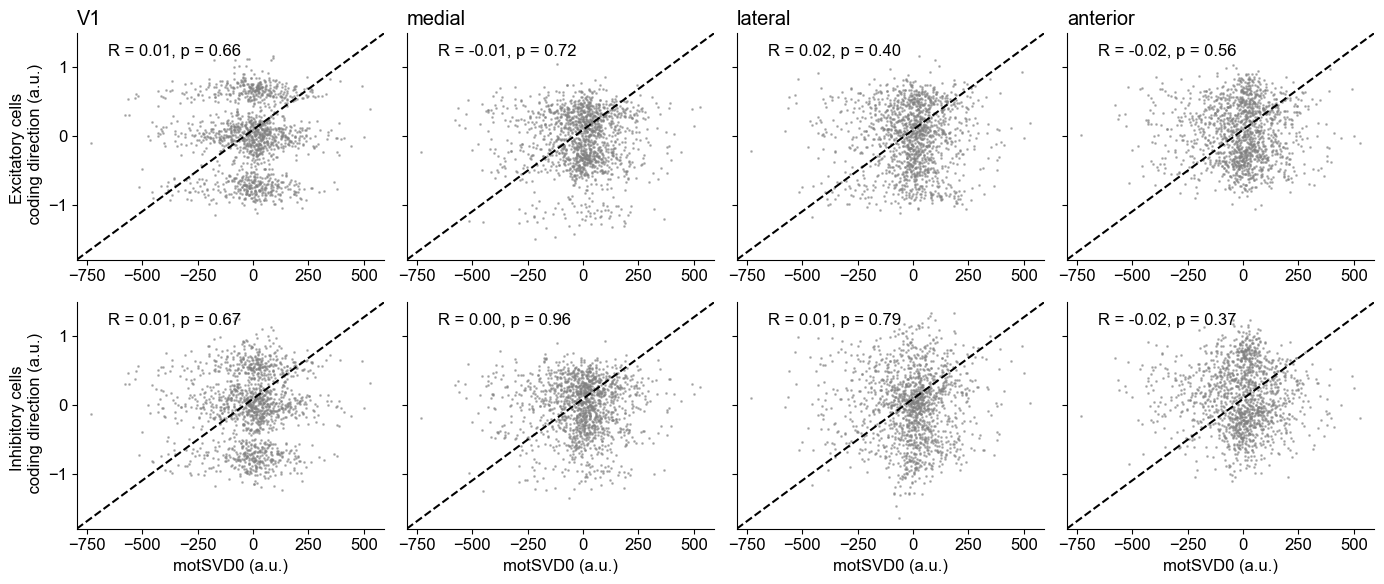

In [417]:
fig, ax = plt.subplots(2,4, figsize=(14, 6), sharey=True)
for icell in range(2):
    ax[icell,0].set_ylabel(f"{'Excitatory' if icell == 0 else 'Inhibitory'} cells \n coding direction (a.u.)")
    for ia in range(4):
        R, p = pearsonr(np.concatenate(mot_svds[:,ia,icell]), np.concatenate(cod_dirs[:,ia,icell]))
        ax[icell,ia].plot([0, 1], [0, 1], transform=ax[icell,ia].transAxes, color='k', linestyle='--')
        ax[icell,ia].scatter(np.concatenate(mot_svds[:,ia,icell]), np.concatenate(cod_dirs[:,ia,icell]), color='grey', alpha=0.5, s=1)
        ax[icell,ia].text(.1, .9, transform=ax[icell,ia].transAxes, s=f"R = {R:.2f}, p = {p:.2f}")
        ax[0,ia].set_title(areas[ia])
        ax[1,ia].set_xlabel("motSVD0 (a.u.)")
plt.tight_layout()

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

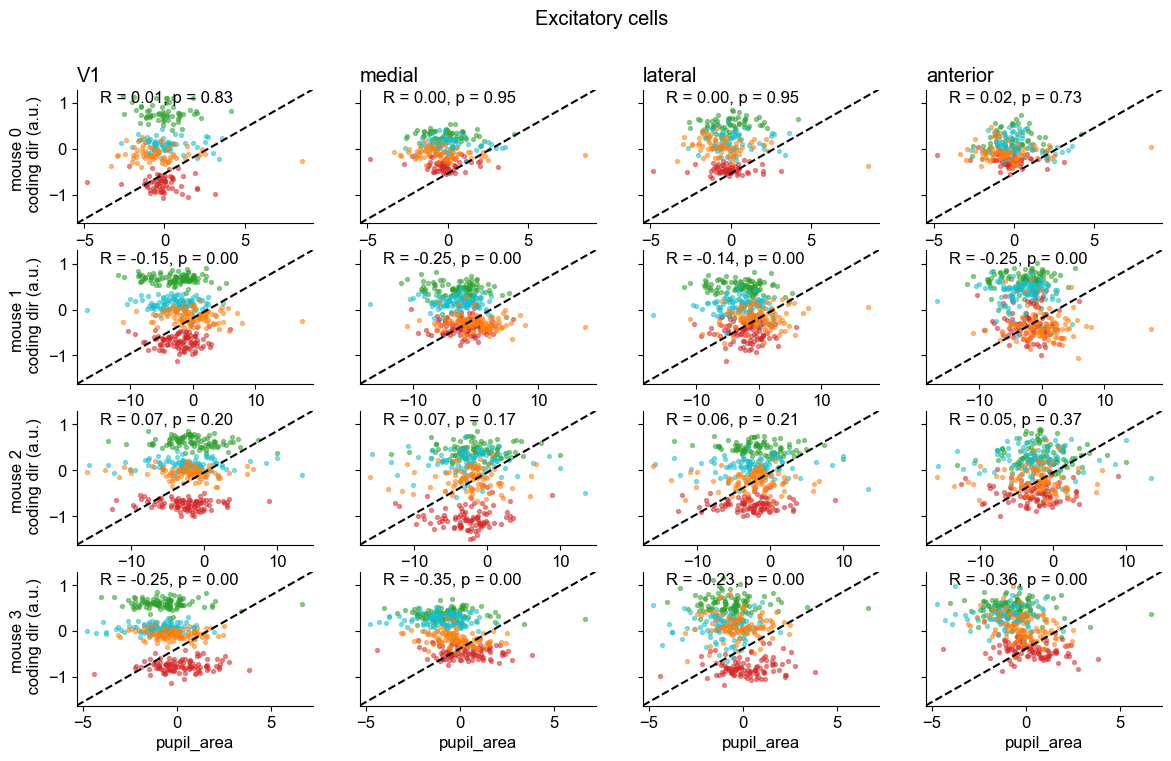

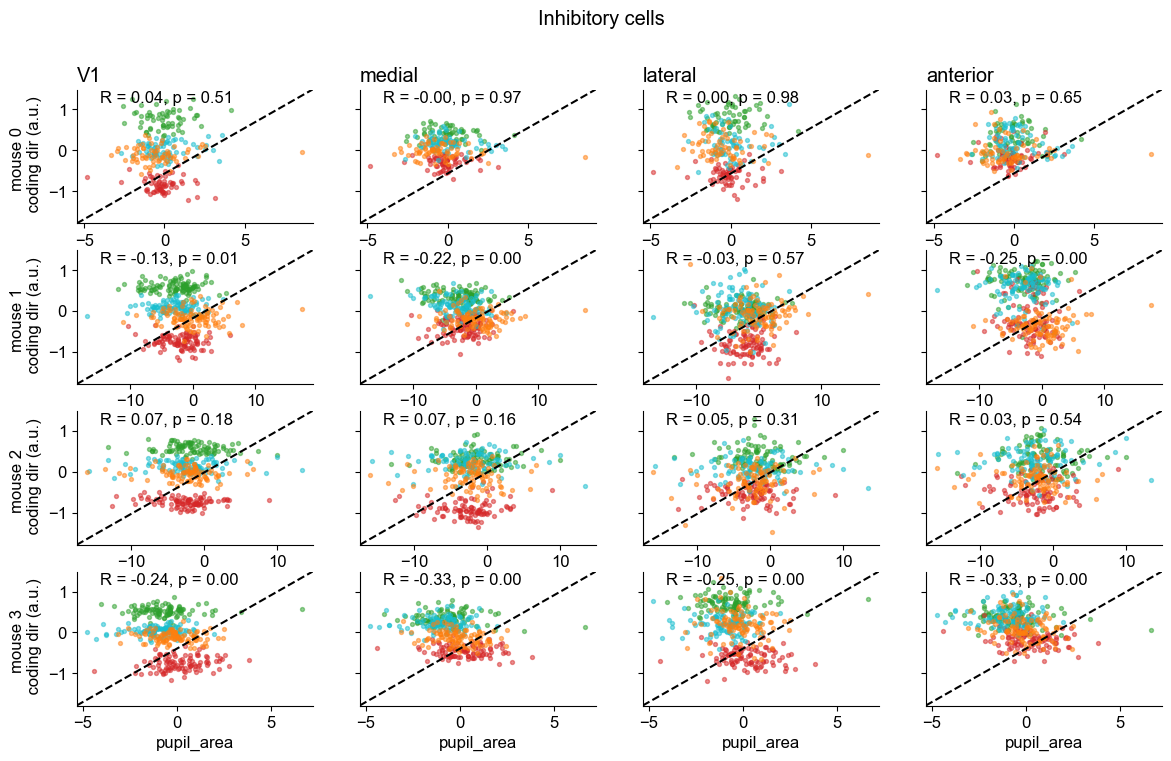

In [373]:
from scipy.stats import pearsonr
areas = ["V1", "medial", "lateral", "anterior"]

for redcell in range(2):
    fig, ax = plt.subplots(4,4, figsize=(14, 8), sharey=True)
    
    if redcell == 0: 
        title = "Excitatory cells"
    else:
        title = "Inhibitory cells"
        fig.suptitle(f"{title}")
    for iss, sess in enumerate(all_sessions):
        name = sess['mname']
        date = sess['datexp']
        blk = sess['blk']
        ax[iss, 0].set_ylabel(f"mouse {iss} \n coding dir (a.u.)")
        m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
        pupil_area = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/pupil_area_corridor.npy")
        pupil_area = pupil_area - np.expand_dims(pupil_area[:,0],axis=1)
        pupil_area = pupil_area[:,:125].mean(axis=1)
        f = [motSVD0, pupil_area]
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
            title = "Excitatory cells"
        else:
            selected_type = m1.isred[:,0].astype(bool)
            title = "Inhibitory cells"
        fig.suptitle(f"{title}")
        for indexa, area in enumerate(areas):
            ax[0, indexa].set_title(area)
            ax[-1, indexa].set_xlabel(f"pupil_area")
            ia = utils.get_region_idx(m1.iarea, area)
            pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
            prefer_r = (m1.train_dp>=pstv_tsh)
            prefer_nr = (m1.train_dp<=ngtv_tsh)
            area_prefer_r = prefer_r * ia * selected_type
            area_prefer_nr = prefer_nr * ia * selected_type
            dir_for_type = m1.interp_spks 
            dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
            avg_dir = dir_for_type.mean(0)
            avg_dir = avg_dir[:,:125].mean(axis=1)
            ax[iss, indexa].plot([0, 1], [0, 1], transform=ax[iss, indexa].transAxes, color='k', linestyle='--')
            ax[iss, indexa].text(.1, .9, transform=ax[iss,indexa].transAxes, s=f"R = {pearsonr(pupil_area, avg_dir)[0]:.2f}, p = {pearsonr(pupil_area, avg_dir)[1]:.2f}")
            for it, (ttype, trials) in enumerate(m1.trial_dict.items()):
                ax[iss, indexa].scatter(pupil_area[trials], avg_dir[trials], color=trial_type_palette[it], label=ttype, alpha=0.5, s=8)
            

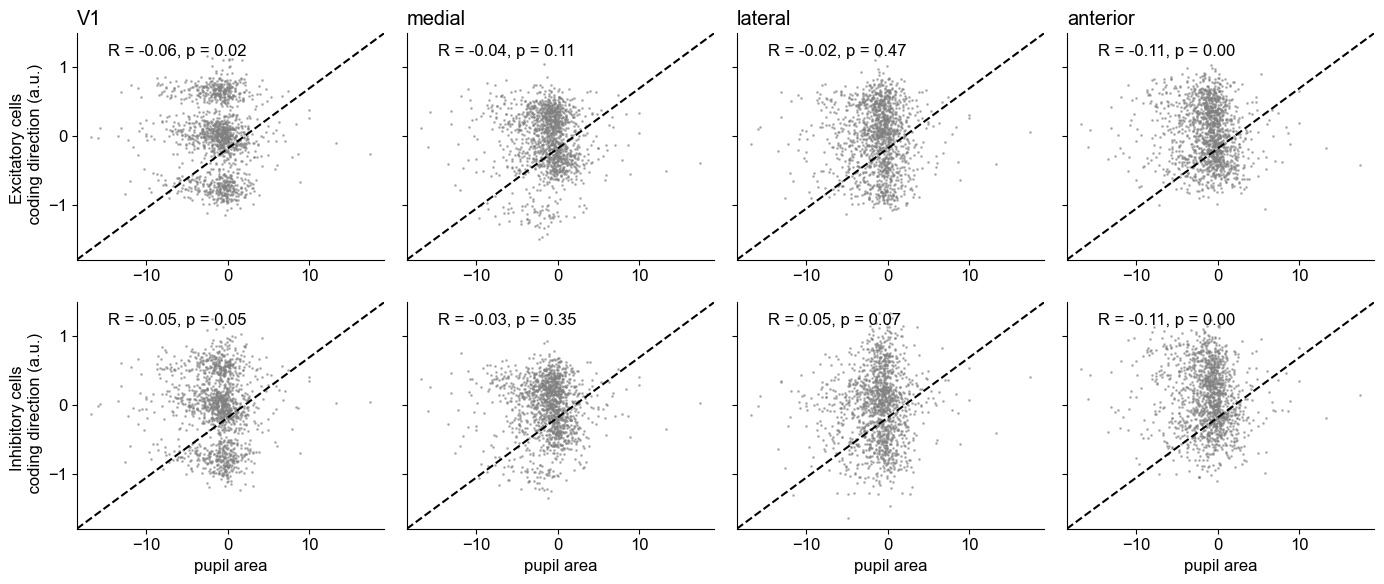

In [418]:
fig, ax = plt.subplots(2,4, figsize=(14, 6), sharey=True)
for icell in range(2):
    ax[icell,0].set_ylabel(f"{'Excitatory' if icell == 0 else 'Inhibitory'} cells \n coding direction (a.u.)")
    for ia in range(4):
        R, p = pearsonr(np.concatenate(pupil_areas[:,ia,icell]), np.concatenate(cod_dirs[:,ia,icell]))
        ax[icell,ia].plot([0, 1], [0, 1], transform=ax[icell,ia].transAxes, color='k', linestyle='--')
        ax[icell,ia].scatter(np.concatenate(pupil_areas[:,ia,icell]), np.concatenate(cod_dirs[:,ia,icell]), color='grey', alpha=0.5, s=1)
        ax[icell,ia].text(.1, .9, transform=ax[icell,ia].transAxes, s=f"R = {R:.2f}, p = {p:.2f}")
        ax[0,ia].set_title(areas[ia])
        ax[1,ia].set_xlabel("pupil area")
plt.tight_layout()

In [56]:
from scipy.interpolate import interp1d
from pathlib import Path
svds_path = Path("Z:\data\Miguel\Facevideos")
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
    cam_proc = load_cam_features(m1, svds_path)
    motion_energy = cam_proc['motion'][1]
    pupil_df = get_pupil_df(m1, svds_path)
    tframes, nframes = get_frametimes(m1)
    camera_time = pupil_df['serialtime'].values
    interp_motion = interp1d(camera_time, motion_energy, fill_value="extrapolate")(tframes)
    cam_df = pd.DataFrame({'motion_energy': interp_motion})
    fselector = pd.merge(m1.frameselector, cam_df, left_index=True, right_index=True)
    interp_motion = interp_to_corridor(fselector, 'motion_energy')
    pth = Path(f"../data/{m1.name}/{m1.datexp}/{m1.blk}")
    np.save(pth/f"motion_energy_corridor.npy", interp_motion)

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

In [ ]:
feature - np.expand_dims(feature[:,0],axis=1)

In [75]:
(np.expand_dims(feature[:,0],axis=1) - feature) / np.expand_dims(feature[:,0],axis=1) * 100

array([[  0.        ,   0.        ,   0.        , ...,  51.62143423,
         52.44502231,  52.44502231],
       [  0.        , -14.82148107, -29.64296213, ..., -85.56706879,
        -89.12022752, -92.67338625],
       [  0.        ,   1.02123474,   2.04246947, ...,   7.12224284,
          6.67978203,   6.23732122],
       ...,
       [  0.        ,  13.70857358,  13.49086291, ...,  -7.49913587,
         -9.80153778, -12.1039397 ],
       [  0.        , -21.12241653, -21.37396179, ..., -40.29711903,
        -43.43093378, -46.56474854],
       [  0.        ,  42.05882003,  39.03453632, ...,  16.32763902,
         17.1512051 ,  17.97477118]])

In [76]:
mean_motion_per_cat = np.empty((len(all_sessions), 2, 400)) # animals, cats,  400 positions
mean_motion_change_per_cat = np.empty((len(all_sessions), 2, 400))
mean_pupil_change_per_cat = np.empty((len(all_sessions), 2, 400))
mean_pupil_per_cat = np.empty((len(all_sessions), 2, 400))
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
    motion = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/motion_energy_corridor.npy")
    pupil_area = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/pupil_area_corridor.npy")
    A_trials = np.concatenate([m1.trial_dict['rewarded'], m1.trial_dict['rewarded test']])
    B_trials = np.concatenate([m1.trial_dict['non rewarded'], m1.trial_dict['non rewarded test']])
    f = [motion, pupil_area]
    for i, feature in enumerate(f):
        feature_no_offset = (np.expand_dims(feature[:,0],axis=1) - feature) / np.expand_dims(feature[:,0],axis=1) * 100
        for it, trials in enumerate([A_trials, B_trials]):
            mean_feature = np.mean(feature_no_offset[trials], axis=0)
            mean_f_offset = np.mean(feature[trials], axis=0)
            if i == 0:
                mean_motion_change_per_cat[iss, it] =  mean_feature
                mean_motion_per_cat[iss, it] =  mean_f_offset
            elif i == 1:
                mean_pupil_change_per_cat[iss, it] =  mean_feature
                mean_pupil_per_cat[iss, it] =  mean_f_offset
np.save("../data/overall/mean_motion_per_cat.npy", mean_motion_per_cat)
np.save("../data/overall/mean_motion_change_per_cat.npy", mean_motion_change_per_cat)
np.save("../data/overall/mean_pupilarea_per_cat.npy", mean_pupil_per_cat)
np.save("../data/overall/mean_pupilarea_change_per_cat.npy", mean_pupil_change_per_cat)

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

In [73]:
np.save("../data/overall/mean_motion_change_per_cat.npy", mean_motion_change_per_cat)